In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc, roc_curve

In [73]:
class LogisticRegression(object):
    def __init__(self, X_train, y_train, X_test, y_test, learn_rate=0.001, n_iters=500):
        if len(X_train.shape) == 1:
            self.X_train = np.hstack((np.array([1]), X_train))
        else:
            self.X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        self.y_train = y_train

        if len(X_test.shape) == 1:
            self.X_test = np.hstack((np.array([1]), X_test))
        else:
            self.X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        self.y_test = y_test

        self.learn_rate = learn_rate
        self.n_iters = n_iters 

        # Initialize model weights
        self.weight = np.zeros((self.X_train.shape[1]))

        self.accuracy_train = []  # To keep track of accuracy on the training data during gradient ascent process
        self.accuracy_test = []  # To keep track of accuracy on the test data during gradient ascent process

        self.log_likelihood_train = []  # To keep track of average log likelihood on the training data during gradient ascent process
        self.log_likelihood_test = []  # To keep track of average log likelihood on the test data during gradient ascent process

    def predict(self, samples, threshold=0.5):
        return self.predict_prob(samples) >= threshold

    def predict_prob(self, samples):
        
        z = np.dot(samples, self.weight)
        # From the lecture slides using the sigmoid function
        prob = 1 / (1 + np.exp(-z))
        return prob
    
    def compute_gradient(self, ):
        # predict prob 
        y_pred = self.predict_prob(self.X_train)
        # compute the error
        error = self.y_train - y_pred
        # compute gradient
        gradient = np.dot(self.X_train.T, error) / len(self.X_train)
        
        return gradient

    def gradient_ascent(self, ):
        #Run gradient ascent to learn model weights
        for i in range(self.n_iters):
            gradient = self.compute_gradient()
            self.weight += self.learn_rate * gradient
       
        #Store the average log likelihood and the prediction accuracy 
        #       on the training and test sets after every gradient ascent iteration
        
            y_pred_train = self.predict_prob(self.X_train)
            y_pred_test = self.predict_prob(self.X_test)
            
            log_ll_train = np.sum(self.y_train * np.log(y_pred_train) + (1 - self.y_train) * np.log(1 - y_pred_train))
            log_ll_test = np.sum(self.y_test * np.log(y_pred_test) + (1 - self.y_test) * np.log(1 - y_pred_test))
            
            accuracy_train = np.mean(self.predict(self.X_train))
            accuracy_test = np.mean(self.predict(self.X_test))
            
            self.accuracy_train.append(accuracy_train)
            self.accuracy_test.append(accuracy_test)
            self.log_likelihood_train.append(log_ll_train)
            self.log_likelihood_test.append(log_ll_test)
            
        

In [74]:
def preprocess_data(X_train, X_test):
    # Identify categorical columns and numerical columns
    categorical_cols = X_train.select_dtypes(include=['object']).columns
    numerical_cols = X_train.select_dtypes(exclude=['object']).columns

    # Apply OneHotEncoder to categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)  
    X_train_cat = encoder.fit_transform(X_train[categorical_cols])
    X_test_cat = encoder.transform(X_test[categorical_cols])

    # Apply StandardScaler to numerical columns
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[numerical_cols])
    X_test_num = scaler.transform(X_test[numerical_cols])

    # Combine the transformed categorical and numerical columns
    X_train_processed = np.hstack((X_train_num, X_train_cat))
    X_test_processed = np.hstack((X_test_num, X_test_cat))

    return X_train_processed, X_test_processed


In [75]:
def plot_log_likelihood_performance(log_likelihood_train, log_likelihood_test):
    
    iterations = range(1, len(log_likelihood_train) + 1)

    
    plt.plot(iterations, log_likelihood_train, label='Training Set', color='blue')
    plt.plot(iterations, log_likelihood_test, label='Test Set', color='red')

    plt.xlabel('Iteration')
    plt.ylabel('Average Log Likelihood')
    plt.title('Log Likelihood During Training')
    plt.legend()
    plt.show()

In [76]:
def plot_accuracy_performance(accuracy_train, accuracy_test):
    
    iterations = range(1, len(accuracy_train) + 1)

    plt.plot(iterations, accuracy_train, label='Training Set', color='blue')
    plt.plot(iterations, accuracy_test, label='Test Set', color='red')
    
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracy During Training')

    plt.legend()
    plt.show()

In [77]:
def plot_roc(X_train, y_train, X_test, y_test, learner):
    
    y_train_prob = learner.predict_prob(X_train)
    y_test_prob = learner.predict_prob(X_test)

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='blue', label=f'Training AUC = {auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, color='red', label=f'Test AUC = {auc_test:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [78]:
# Load data
train_data = pd.read_csv('cleaned_train_data.csv')
test_data = pd.read_csv('cleaned_test_data.csv')
X_train = train_data.drop(['income'], axis=1, inplace=False)
y_train = train_data['income']
X_test = test_data.drop(['income'], axis=1, inplace=False)
y_test = test_data['income']
# print(y_train.values.shape)           
# print(y_test.values.shape)  

In [79]:
# Preprocessing data
processed_X_train, processed_X_test = preprocess_data(X_train, X_test)


In [80]:
learner = LogisticRegression(processed_X_train, y_train.values, processed_X_test, y_test.values,
                              n_iters=250, learn_rate=0.05)
learner.gradient_ascent()

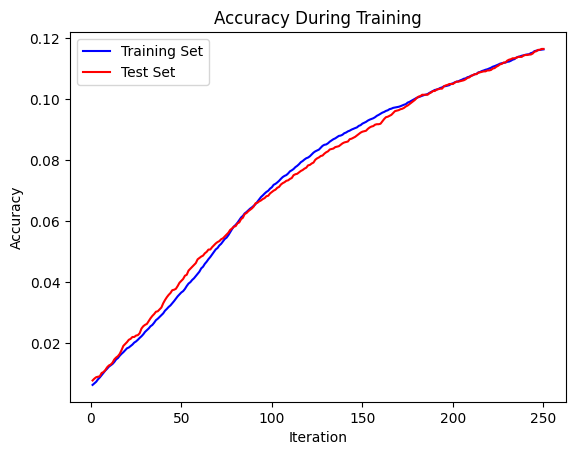

In [81]:
# Plot prediction accuracy during training process
plot_accuracy_performance(learner.accuracy_train, learner.accuracy_test)

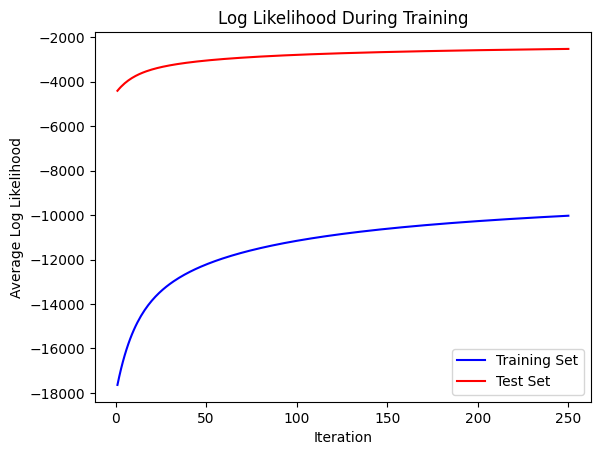

In [82]:
# Plot Log Likelihood values during training process
plot_log_likelihood_performance(learner.log_likelihood_train, learner.log_likelihood_test)

In [83]:
# Plot ROC curves
print(f"Processed X_train shape: {processed_X_train.shape}")  # Should be (26049, 89)
print(f"Processed X_test shape: {processed_X_test.shape}")    # Should be (6512, 89)
print(f"Weight vector shape: {learner.weight.shape}")   
plot_roc(processed_X_train, y_train, processed_X_test, y_test, learner)

Processed X_train shape: (26049, 88)
Processed X_test shape: (6512, 88)
Weight vector shape: (89,)


ValueError: shapes (26049,88) and (89,) not aligned: 88 (dim 1) != 89 (dim 0)